<center> <h1> Variational Autoencoder using Pytorch </h1> </center>

## Introduction

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from image_utils import load_images_from_path

In [10]:
input_shape = (190,105)

## 1. Sampling

We implement the sampling class in order to use the reparameterization trick. In fact, this trick is used in VAEs to sample from the posterior distribution of the latent space variables (z) given the inputs (z_mean, z_log_var) while keeping the sampling process differentiable, enabling backpropagation and gradient-based optimization.

The principle is to transform the random samples from a standard normal distribution $ \sim \mathcal{N}(0,\,1)$ using the following equation:
        
Reparameterization Trick:

$$ z = z_{\text{mean}} + \exp\left(\frac{1}{2} z_{\text{log\_var}}\right) \cdot \epsilon $$

where $ \epsilon $ is a random sample from the standard normal distribution $\sim \mathcal{N}(0,\,1)$.

In [11]:
class Sampling(nn.Module):
    """
    Implementation of the reparameterization trick (to make the sampling process differentiable) used in VAEs to sample from the
    posterior distribution of the latent space variables (z) given the inputs (z_mean, z_log_var).

    Parameters:
        inputs (tuple): A tuple containing two tensors : z_mean and z_log_var.

    Returns:
        torch.Tensor: A tensor containing the reparameterized latent variables z.
                      The shape of the output tensor is the same as z_mean and z_log_var.
    """

    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        # generates random samples from a standard normal distribution 
        epsilon = torch.randn(batch, dim, device=z_mean.device)
        #The reparameterization trick
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon 

## 2. Encoder

The encoder is a neural network used to map input images of the crops to a triplet (z_mean, z_log_var, z) in the context of a Variational Autoencoder (VAE) architecture. 

 The Encoder takes input image crops and processes them through a series of fully connected layers with ReLU activations to compress the input into a compact representation in the latent space. The architecture consists of three hidden layers with decreasing dimensions, followed by two output layers for the mean and log variance of the latent space distribution. 

**PS: Idea of using dense layers instead of conv layers**

In [12]:
class Encoder(nn.Module):
    """
    Encoder neural network that maps input image crops to a triplet (z_mean, z_log_var, z).
    """

    def __init__(self, n_rows=190 ,n_cols=105 ,n_channels=1, h_dim3 = 32, h_dim2 = 64, h_dim1 = 128, latent_dim=32):
        super(Encoder, self).__init__()
        
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.latent_dim = latent_dim
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(n_channels * n_rows * n_cols, h_dim1)
        self.fc1 = nn.Linear(h_dim1, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim3)
        
        self.dense_mean = nn.Linear(h_dim3, self.latent_dim)
        self.dense_log_var = nn.Linear(h_dim3, self.latent_dim)
        self.sampling = Sampling()

    def forward(self, inputs):
        x = self.flatten(inputs)
        x = F.relu(self.dense(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

## 3. Decoder

 The decoder architecture maps the latent variables to the original image space by sequentially transforming and upsampling the latent representation through fully connected layers, followed by a final Sigmoid activation to generate the reconstructed image in the original format.

In [13]:
class Decoder(nn.Module):
    """
    Decoder neural network that maps latent variables (z) back to the original image space.
    """

    def __init__(self, n_rows=190 ,n_cols=105 ,n_channels=1, h_dim3 = 32, h_dim2 = 64, h_dim1 = 128, latent_dim=32):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = n_rows * n_cols
  
        

        # Decoder layers
        self.dense = nn.Linear(self.latent_dim, h_dim3)
        self.fc1 = nn.Linear(h_dim3, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc3 = nn.Linear(h_dim1, n_channels * n_rows * n_cols)
        

    def forward(self, z):
        x = F.relu(self.dense(z))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.view(-1, self.n_channels, self.n_rows, self.n_cols)


## 4. The VAE


In [14]:
class BetaVAE(nn.Module):

    def __init__(self, beta = 1.0, n_rows=190 ,n_cols=105 ,n_channels=1, h_dim3 = 32, h_dim2 = 64, h_dim1 = 128, latent_dim=32):
        super(BetaVAE, self).__init__()

        self.encoder = Encoder(n_rows, n_cols, n_channels, h_dim3, h_dim2, h_dim1, latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(n_rows, n_cols, n_channels, h_dim3, h_dim2, h_dim1, latent_dim)
        self.beta = beta

    def forward(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed_image = self.decoder(z)
        return reconstructed_image,z_mean,z_log_var

    def loss_function(self, reconstructed, original, z_mean, z_log_var):

        # Reconstruction loss (pixel-wise mean squared error)
        reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')

        # KL-divergence loss
        kl_divergence_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        # Total loss
        total_loss = reconstruction_loss + self.beta * kl_divergence_loss

        return total_loss, reconstruction_loss, kl_divergence_loss

In [15]:
def train_VAE(crops, n_rows=190, n_cols=105, latent_dim=8, beta=1, epochs=20, batch_size=32,
                  learning_rate=1e-3, validation_split=0.2, plot_history=True,
                  save_model=True, saving_path='./newmodel'):


    def __plot_history(history):
        plt.figure(figsize=(10, 5))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # model_name = "model_zdim_" + str(latent_dim)+"_beta_"+ str(beta)+"_epochs_"+str(epochs)
        # plt.savefig('./models/loss_'+model_name+'.png')
        plt.show()
        

    # Convert the crops to a PyTorch tensor
    crops = torch.tensor(crops)

    # Create an instance of the BetaVAE model
    vae = BetaVAE(beta=beta, latent_dim=latent_dim)

    # Define the optimizer
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

    # Lists to store loss history for plotting
    train_loss_history = []
    val_loss_history = []

    # Split the data into training and validation sets
    split_idx = int((1 - validation_split) * len(crops))
    # Shuffle the data before splitting it
    size_dim_0 = crops.size(0)
    shuffled_indices_dim_0 = torch.randperm(size_dim_0)
    crops = crops[shuffled_indices_dim_0, ...]
    train_data = crops[:split_idx]
    val_data = crops[split_idx:]
    print("the training data has ",train_data.size(dim=0), " patches")
    print("the validation data has ",val_data.size(dim=0), " patches")

    # Training loop
    for epoch in range(epochs):
        vae.train()
        
         # Shuffle the training data
        dim_0 = train_data.size(0)
        shuffled_indices_dim_0 = torch.randperm(dim_0)
        train_data = train_data[shuffled_indices_dim_0, ...]
        
        total_train_loss = 0

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            optimizer.zero_grad()
            reconstructed,z_mean,z_log_var = vae(batch)
            loss, reconstruction_loss, kl_divergence_loss = vae.loss_function(
                reconstructed, batch, z_mean, z_log_var
            )
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_data)
        train_loss_history.append(avg_train_loss)

        # Validation
        vae.eval()
        with torch.no_grad():
            total_val_loss = 0

            for i in range(0, len(val_data), batch_size):
                batch = val_data[i:i+batch_size]
                reconstructed, z_mean, z_log_var = vae(batch)
                loss, _, _ = vae.loss_function(reconstructed, batch, z_mean, z_log_var)
                total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_data)
            val_loss_history.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if plot_history:
        history = {'loss': train_loss_history, 'val_loss': val_loss_history}
        __plot_history(history)

    if save_model:
        torch.save(vae.state_dict(), saving_path)

    return vae

the training data has  5849  patches
the validation data has  1463  patches
Epoch [1/25] - Train Loss: 554.4177 - Val Loss: 156.4824
Epoch [2/25] - Train Loss: 150.5002 - Val Loss: 134.1554
Epoch [3/25] - Train Loss: 129.0175 - Val Loss: 114.5244
Epoch [4/25] - Train Loss: 117.4513 - Val Loss: 108.3104
Epoch [5/25] - Train Loss: 112.9841 - Val Loss: 105.1679
Epoch [6/25] - Train Loss: 110.2914 - Val Loss: 102.9130
Epoch [7/25] - Train Loss: 108.0615 - Val Loss: 101.9911
Epoch [8/25] - Train Loss: 106.4609 - Val Loss: 100.9605
Epoch [9/25] - Train Loss: 105.1266 - Val Loss: 100.3471
Epoch [10/25] - Train Loss: 104.1163 - Val Loss: 97.7357
Epoch [11/25] - Train Loss: 102.8283 - Val Loss: 97.1675
Epoch [12/25] - Train Loss: 102.3020 - Val Loss: 97.2780
Epoch [13/25] - Train Loss: 101.2529 - Val Loss: 95.5602
Epoch [14/25] - Train Loss: 100.6333 - Val Loss: 96.5246
Epoch [15/25] - Train Loss: 100.0476 - Val Loss: 94.1845
Epoch [16/25] - Train Loss: 99.2792 - Val Loss: 94.3981
Epoch [17/25]

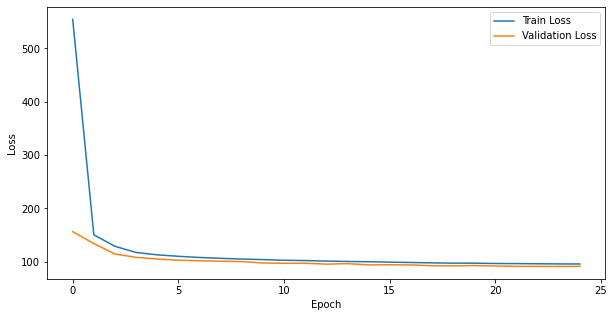

In [16]:
data_path = '../segmentation/data_for_VAE/220429_ MCF10A  laminAC fibro phallo pattern mars 2022\*.png'
_,crops = load_images_from_path(data_path)
crops = np.expand_dims(crops, axis=1).astype("float32") / 255
batch_size = 32  # You can adjust this based on your hardware and memory limitations
latent_dim = 8
beta = 1
epochs = 25
model_name = "model_zdim_" + str(latent_dim)+"_beta_"+ str(beta)+"_epochs_"+str(epochs)
trained_vae = train_VAE(crops, n_rows=190, n_cols=105, latent_dim=latent_dim, beta=beta, epochs=epochs,
                        batch_size=batch_size, learning_rate=1e-3, validation_split=0.2,
                        plot_history=True, save_model=True, saving_path='./models/'+model_name+".pth")

In [17]:
model = BetaVAE(beta=1, latent_dim=8)
model.load_state_dict(torch.load('./models/model_zdim_8_beta_1_epochs_50.pth'))
model.eval()

BetaVAE(
  (encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=19950, out_features=128, bias=True)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (dense_mean): Linear(in_features=32, out_features=8, bias=True)
    (dense_log_var): Linear(in_features=32, out_features=8, bias=True)
    (sampling): Sampling()
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (dense): Linear(in_features=8, out_features=32, bias=True)
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=19950, bias=True)
  )
)